# Notes on Using Divergence Functions

The **mvtk.supervisor.divergence** contains several functions that compute **total variation** between two data distributions. However, these functions have very different mechanisms for arriving at total variation. Some functions, such as **calc_tv** use a neural network under the hood, while others such as **calc_tv_knn** use a different mechanism to arrive at the range of values to inform on whether two distributions are more similar or not. Because of these differences, there functions are often best suited for different circumstances, be it data size, computational resources, or accuracy requirements. This notebook provides a guide to when and how to use the functions.


In [1]:
import numpy as np
import warnings
from IPython.display import display
from ipywidgets import HTML
warnings.filterwarnings('ignore')
from mvtk.supervisor.divergence import calc_tv, calc_tv_knn, calc_tv_density, calc_tv_mle, calc_kl_mle, calc_hl
from mvtk.supervisor.utils import column_indexes

## Data Types

The algorithms underneath the divergence functions all operate on **numpy arrays**. A divergence function compares a **sample_a** vs a **sample_b**, where a sample is either an array 

```
def divergence_function(sample_a, sample_b, **kwargs):
    algorithm
```
**OR** a *list of arrays*

```
def divergence_function([sample_a], [sample_b], **kwargs):
    algorithm
```

The functions that accept lists allow you to test one *list of batches* against another *list of batches*. For example,  
```
sample_a = [batch1, batch2, batch3] 
sample_b = [[batch5, batch6]
```

This will compare the average of the distributions that generated `batch1`, `batch2`, and `batch3` to the average of the distributions that generated `batch4` and `batch5`. You can just use singletons to compare `batch1` to `batch2`, i.e.
```
sample_a = [batch1] 
sample_b = [batch2]
```

For the divergence functions that you intend to use, you should check the documentation as to whether it accepts lists or arrays.


## Using Dataframes

Pandas dataframes are a perfect input source for the divergence functions. The underlying storage for dataframes are numpy arrays on which all divergence functions can operate.

If your data is in **Pyspark** dataframes then you either convert to pandas dataframes, or numpy arrays.

In [2]:
import pandas as pd
df = pd.DataFrame({'weight': np.random.uniform(1, 100, size=(10000)),
                  'colors': np.random.choice(['red', 'blue', 'green', 'yellow'], p=[0.2, 0.3, 0.3, 0.2])})
df.head(3)

,weight,colors
0,79.360725,green
1,92.373537,green
2,91.021177,green


## Create Data Distributions

For data, we will create datasets drawn from different distributions. We will use about a **million rows**, and about **100** columns.

Each row in a dataset becomes a training example to be used in the neural network that calculates the divergence. If you have too few rows, then the divergence value will not be calculated accurately, and in practice will be close to zero.

In [3]:
ROWS, COLUMNS = 1000000, 10
DATA_SHAPE = ROWS, COLUMNS

In [4]:
samples = dict()
uniform_a   = samples['uniform_a']   = np.random.uniform(1, 100, size=DATA_SHAPE)
uniform_b   = samples['uniform_b']   = np.random.uniform(1, 100, size=DATA_SHAPE)
beta_a      = samples['beta_a']      = np.random.beta(0.2, 0.9, size=DATA_SHAPE)
chisquare_a = samples['chisquare_a'] = np.random.chisquare(2,DATA_SHAPE)
ones        = samples['ones']        = np.ones(DATA_SHAPE)

funcs = {'calc_tv': calc_tv}

### Visualizing the distributions
Let's visualize each of our probability distributions. In this case, each of the `COLUMNS=10` features has exactly the same distribution and they are all independent of eachother, so the following function just lumps all of the samples together. In general, you would _not_ want to do this!

In [5]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns; sns.set()

def distplot(series, title=None):
    if isinstance(series, pd.Series):
        series = series.values
    sns.distplot(series.ravel())
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if title:
        plt.title(title)

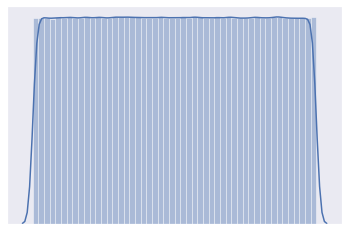

In [6]:
distplot(uniform_a)

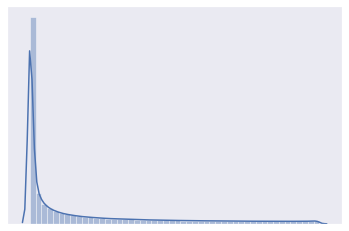

In [7]:
distplot(beta_a)

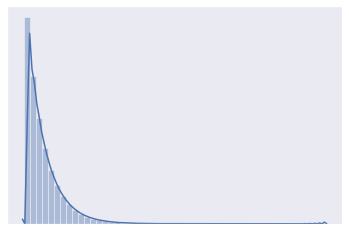

In [8]:
distplot(chisquare_a)

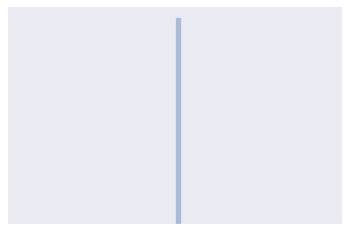

In [9]:
distplot(ones)

## Calculating Total Variation
The main divergence functions calculate the total variation between distributions. However, there are very different ways to arrive at a range of 0-1 with 0 meaning no divergence, and 1 meaning total divergence. This presents users with different approaches with benefits that match different circumstances and dta sizes.

## calc_tv
Computes the total variation between two distributions.

See https://en.wikipedia.org/wiki/Total_variation_distance_of_probability_measures
It uses a neural network to calculate the total variation between distributions. Since it uses a neural network internally, it exposes some familar settings such as the num_epochs, num_batches etc. which you can tune for greater accuracy.  

`sample_distribution_p` *The first distribution*

`sample_distribution_q` *The second distribution*

`categorical_columns` If using a dataframe, the categorical columns

`num_epochs` The number of epochs to train for

`num_batches`


Additionally, you can use `model_generator_kwargs` to set `model_generator` default `**kwargs`. Of particular importance are:

`depth` The number of layers of the neural network. Defaults to `3`

`width` The size of the hidden layer

In [10]:
calc_tv(uniform_a, uniform_b)

0.0004881620407104492

If two distributions are different then the divergence will be close to one.

In [11]:
calc_tv(uniform_a, ones)

0.9995993375778198

You can get better accuracy by changing the default parameters - in this case **num_epochs=16, num_batches=128, depth=2, width=32**

In [12]:
calc_tv(uniform_a, ones, num_epochs=16, num_batches=128, model_generator_kwargs={'width': 32, 'depth': 2})

0.999308705329895

In [13]:
calc_tv(uniform_a, chisquare_a)

0.9999822974205017

In [14]:
calc_tv(uniform_a, [pd.DataFrame(chisquare_a), ones])

0.9989728927612305

In [15]:
calc_tv([uniform_a, ones],[chisquare_a])

0.5061822533607483

## calc_hl

Calculate divergence using Hellinger distance. 

See https://en.wikipedia.org/wiki/Hellinger_distance

**sample_distribution_p** *The first distribution*

**sample_distribution_q** *The second distribution*

Additionally, you can use `model_generator_kwargs` to set `model_generator` default `**kwargs`. Of particular importance are:

`depth` The number of layers of the neural network. Defaults to `3`

`width` The size of the hidden layer

In [16]:
calc_hl(uniform_a, uniform_b)

0.0

In [17]:
calc_hl(uniform_a, chisquare_a)

0.0

**calc_hl** finds a significant divergence between the beta and chisquare distributions

In [18]:
calc_hl(beta_a, chisquare_a)

0.9981940472630377

## calc_tv_knn

Computes the total variation between two distributions. Because it uses KNN which is a fairly simple algorithm it is often faster to compute that **calc_tv**. However, you will want to take care to set the function parameters based on your data dimensions in order for it to get the best accuracy.

**sample_distribution_p** *The first distribution*

**sample_distribution_q** *The second distribution*

**bias**

**num_samples** *Number of subsamples to take
            from each distribution on which to construct kdtrees and
            otherwise make computations. Defaults to 2046*

**categorical_columns**

**k** *number of nearest neighbours. As a rule of
            thumb, you should multiply this by two with every dimension
            past one. Defaults to 128*

Here is an example of using the default parameters for **calc_tv_knn** on similar distributions.

In [19]:
calc_tv_knn(uniform_a, uniform_b)

0.03465665858242252

In this example, **calc_tv_knn** picks up a divergence between the **uniform** and **beta** distributions

In [20]:
calc_tv_knn(uniform_a, beta_a, k=20)

0.8272527964149479

and between the uniform and chisquare distributions

In [21]:
calc_tv_knn(uniform_a, chisquare_a)

0.9306603225843605

**KNN** is an unbiased estimator and will sometimes overshoot. 

In [22]:
calc_tv_knn(beta_a, chisquare_a)

1.20928344516188

One way to address this is to set the value of **k neighbours** to **2 * the number of dimensions**. There are 10 columns so we set k to **20**.

In [23]:
calc_tv_knn(beta_a, chisquare_a, k = 20)

1.1124090464149479

In [24]:
calc_tv_knn(beta_a, beta_a, k=20)

0.07457887528399548

## Density Based Estimators

Density estimation is the problem of reconstructing the probability density function using a set of given data
points.

## calc_tv_density

In [25]:
calc_tv_density(uniform_a, uniform_b)

165011946.1532011

In [26]:
calc_tv_density(uniform_a, beta_a)

251557894.78209227

## Handling Categorical Data
If your data is all categorical, then you would probably want to use **calc_tv_mle**. 

For these examples, we will create categorical columns drawn from different distributions.

In [27]:
FRUITS, FRUIT_PROBS = ['apple', 'orange', 'plum', 'raspberry', 'blueberry'], [0.1, 0.3, 0.3, 0.25, 0.05]
assert sum(FRUIT_PROBS) ==1

raspberry_blast = np.random.choice(FRUITS,size=(1000000, 10), p=FRUIT_PROBS)
blueberry_blast = np.random.choice(FRUITS,size=(1000000, 10), p=FRUIT_PROBS)
plain_smoothie = np.random.choice(FRUITS, size=(1000000, 10))

## calc_tv_mle

Computes the total variation between two distributions using histogram based density estimators. All
 columns are assumed to be categorical.

**sample_distribution_p** *The first distribution*

**sample_distribution_q** *The second distribution*

In [28]:
raspberry_blast[0]

array(['orange', 'apple', 'plum', 'plum', 'plum', 'plum', 'orange',
       'raspberry', 'plum', 'orange'], dtype='<U9')

The samples **raspberry_blast** and **plain_smoothie** have been drawn from different distributions and so we expect to see a high **total variation**.

In [29]:
calc_tv_mle(raspberry_blast, plain_smoothie)

0.9319870000000001

But the samples **raspberry_blast** and **plain_smoothie** have been drawn from similar distributions and so we expect to see lower total variation.



In [30]:
calc_tv_mle(raspberry_blast, blueberry_blast)

0.6263819999999999

## calc_kl_mle

When the second distribution is zero when the first distribution is nonzero for categorical data, kl divergence will hit infinity. For histograms derived from high dimensional categorical data this becomes likely.

In [31]:
calc_kl_mle(raspberry_blast, plain_smoothie)

inf

## Handling Mixed Data

If your data contains categorical columns, then you need to specify the indices of the categorical columns. To demonstrate this, we will create a dataframe with one categorical column and one numeric column, then compute the total variation.

In [32]:
NUM_ITEMS = 100000
inventory_a = pd.DataFrame({'fruits': np.random.choice(FRUITS,size=NUM_ITEMS, p=FRUIT_PROBS), 
                          'weight': np.random.uniform(1, 100, size=NUM_ITEMS).tolist()})

inventory_b = pd.DataFrame({'fruits': np.random.choice(FRUITS,size=NUM_ITEMS), 
                            'weight': np.random.beta(0.2, 0.9, size=NUM_ITEMS).tolist()})

In [33]:
inventory_a.head(4)

,fruits,weight
0,plum,9.043091
1,orange,82.114676
2,raspberry,31.065103
3,raspberry,64.049112


In [34]:
inventory_b.head(4)

,fruits,weight
0,plum,0.001619
1,plum,0.000238
2,raspberry,0.978383
3,orange,0.514946


Now we can use **calc_tv_knn**, setting **k=4** since there are only two columns

In [35]:
calc_tv_knn(inventory_a, inventory_b, categorical_columns=[0], k=4)

0.664169492122229

If you use **calc_tv_knn** on the same data you get a lower value since it's the same distribution

In [36]:
calc_tv_knn(inventory_a, inventory_a, categorical_columns=[0], k=4)

0.216708554622229